# Reddit Data Pre-Processing

In [2]:
import json
import os
import sys
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import nltk
from nltk import sent_tokenize, word_tokenize
%matplotlib inline  
pd.options.display.max_colwidth = 500

### Enter All Directory Info In Cell Below

My directory structure (Brandon) and (Ivan):
```
reddit_data
    raw_data
        2007
        ...
        2015
    processed_data
        2007
        ...
        2015
```
Only info that needs to be changed to run this notebook is in the cell below.

In [3]:
print("You are currently in", os.getcwd(), "\n")
DATA_ROOT = '/home/brandon/terabyte/Datasets/reddit_data' 
# Determine if this directory exists, if not use Ivan's directory.
if (os.path.isdir(DATA_ROOT)):
    pass
else:
    DATA_ROOT = '/Users/ivan/Documents/sp_17/reddit_data'
DATA_YEAR = '2007'
# Use os.path.join; it will figure out the '/' in between.
RAW_DATA_FILES = os.listdir(os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR))
# Always work with full pathnames to be safe.
RAW_DATA_FILES = [os.path.join(DATA_ROOT, 'raw_data', DATA_YEAR, file) for file in RAW_DATA_FILES 
                  if not file.startswith('.')]
pprint(RAW_DATA_FILES)

You are currently in /home/brandon/Documents/seq2seq_projects/notebooks 

['/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-10',
 '/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-11',
 '/home/brandon/terabyte/Datasets/reddit_data/raw_data/2007/RC_2007-12']


## Load Data and Display Basic Info

In [4]:
def load_data():
    df = pd.read_json(RAW_DATA_FILES[0], lines=True)
    init_num_rows = len(df)
    print("Number of lines in raw data file", init_num_rows)
    pprint("Column names from raw data file:")
    pprint(df.columns, width=100)
    return df

In [5]:
def show_len_update(df):
    print("Now there are", len(df), "rows.")
    
def root_comments(df):
    '''Build list determining which rows of df are root comments.
    
    Returns: 
        list of length equal to the number of rows in our data frame. 
    '''
    root_value = []
    # Iterate over DataFrame rows as namedtuples, with index value as first element of the tuple.
    for row in df.itertuples():
        root_value.append(row.parent_id == row.link_id)
    return root_value

def random_rows_generator(num_rows_per_print, num_rows_total):
    num_iterations = num_rows_total // num_rows_per_print 
    shuffled_indices = np.arange(num_rows_per_print * num_iterations)
    np.random.shuffle(shuffled_indices)
    for batch in shuffled_indices.reshape(num_iterations, num_rows_per_print):
        yield batch
        
#rand_rows = random_rows_generator(4, len(df))

### Initial Clean up

* Start by removing comments without a body (deleted).
* Remove comments larger than 150 words long.
* Remove unneccesary columns. 
* Add a column determining whether a row is a root comment.

In [6]:
def initial_clean(df):
    df['root'] = root_comments(df)
    df = df[['author', 'body', 'link_id', 'parent_id', 'name', 'root', 'subreddit']]
    df.style.set_properties(subset=['body'], **{'width': '500px'})
    df.style.set_properties(**{'text-align': 'left'})
    show_len_update(df)
    df.head()
    return df

#### Remove Unwanted String Patterns in Body

### Keep track of modifications for analysis

The 'mods' field in our df will keep a record of the different modifications we have made. 
We have created a simple numeric system where different values corresponds to different changes:

| Modification | Value  |
|--------------|--------|
| Newline      | 1      |
| Greater/Less | 10     |
| Links        | 100    |
| Numbers      | 1000   |
| Special Char | 10000  |
| Ellipsis     | 100000 |


In [7]:
modify_list = [('\r\n', ' '),
               ('\n', ' '),
               ('\r', ' '),
               ('&gt;', ' '),
               ('&lt;', ' '),
               ('/__|\*|\#|(?:\[([^\]]*)\]\([^)]*\))/gm', '[link]'),
               ('https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,}', '[link]'),
               ('\d+', 'NUMBER'),
               ('\[', ''),
               ('\]', ''),
               ('\/\/', ''),
               ('\.\.\.', '. ')
              ]

modify_value = {'\r\n': 1,
               '\n': 1,
               '\r': 1,
               '&gt;': 10,
               '&lt;': 10,
               '/__|\*|\#|(?:\[([^\]]*)\]\([^)]*\))/gm': 100,
               'https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,}': 100,
               '\d+': 1000,
               '\[': 10000,
               '\]': 10000,
               '\/\/': 10000,
               '\.\.\.': 100000
              }

In [8]:
def clean_with_tracking(df):
    df = df.loc[df.body != '[deleted]'].reset_index(drop=True)
    df.style.set_properties(subset=['body'], **{'width': '800px'})
    df['body'] = df['body'].map(lambda s: s.strip().lower())
    
    total_mods = {}
    if 'mods' not in df: 
        df['mods'] = np.zeros(len(df['body']), dtype=int)
    for patrn in modify_list:
        new_df = df['body'].replace({patrn[0]: patrn[1]}, regex=True, inplace=False)
        modifications = list((np.where(new_df.values != df['body'].values))[0])
        df['body'] = new_df
        df['mods'][modifications] += modify_value[patrn[0]]
        total_mods[patrn[0]] = len(modifications)
    return df, total_mods

In [9]:
df = load_data()
df = initial_clean(df)
df, total_mods = clean_with_tracking(df)

Number of lines in raw data file 150429
'Column names from raw data file:'
Index(['archived', 'author', 'author_flair_css_class', 'author_flair_text',
       'body', 'controversiality', 'created_utc', 'distinguished', 'downs',
       'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id',
       'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id',
       'ups'],
      dtype='object')
Now there are 150429 rows.


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
df.head()

,author,body,link_id,parent_id,name,root,subreddit,mods
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com,0
1,igiveyoumylife,"much smoother. im just glad reddit is back, linkreddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com,20101
2,Arve,"can we please deprecate the word ""ajax"" now? (but yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com,1
3,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com,100000
4,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com,100000


In [11]:
# Misc.
print("Update: How're you feeling?")
df['body'] = df['body'].map(lambda s: s.strip().lower())
df['body'].replace({'  ': ' '}, regex=True, inplace=True)
df['body'].replace({'\[*.\]\(*.\)': '[link]'}, regex=True, inplace=True) # My simpler Markdown link matcher.
print("Update: Because I feel fine.")
df['body'].replace({'\d+': 'NUMBER'}, regex=True, inplace=True)
df['body'].replace({'\[': ''}, regex=True, inplace=True)
df['body'].replace({'\]': ''}, regex=True, inplace=True)
df['body'].replace({'\/\/': ''}, regex=True, inplace=True)
df['body'].replace({'\.\.\.': '. '}, regex=True, inplace=True)
#df['body'].replace({'\s*': ' '}, regex=True, inplace=True)
show_len_update(df)
df.head()

Update: How're you feeling?
Update: Because I feel fine.
Now there are 126320 rows.


,author,body,link_id,parent_id,name,root,subreddit,mods
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com,0
1,igiveyoumylife,"much smoother. im just glad reddit is back, linkreddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com,20101
2,Arve,"can we please deprecate the word ""ajax"" now? (but yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com,1
3,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com,100000
4,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com,100000


In [12]:
df.loc[:10]['body']

0                                                                                                                                                                         test
1     much smoother. im just glad reddit is back, linkreddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.
2                                                                                               can we please deprecate the word "ajax" now?  (but yeah, this _is_ much nicer)
3                                                                                                                                    oh, i see. fancy schmancy "submitting. ."
4                                                                                                                                                                    testing .
5                                                                                                                            

* Remove rows where body is over n words long.

In [13]:
n = 80
print("Length before:", df['body'].size)
df = df[df['body'].map(lambda s: len(s.split(' '))) < n].reset_index(drop=True)
show_len_update(df)
df.head()

Length before: 126320
Now there are 111135 rows.


,author,body,link_id,parent_id,name,root,subreddit,mods
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com,0
1,igiveyoumylife,"much smoother. im just glad reddit is back, linkreddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com,20101
2,Arve,"can we please deprecate the word ""ajax"" now? (but yeah, this _is_ much nicer)",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com,1
3,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com,100000
4,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com,100000


### Use IO_UTIL tokenizer

In [14]:
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had",
        "he'd've": "he would have",
        "he'll": "he shall",
        "he'll've": "he shall have",
        "he's": "he has",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has",
        "I'd": "I had",
        "I'd've": "I would have",
        "I'll": "I shall",
        "I'll've": "I shall have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had",
        "it'd've": "it would have",
        "it'll": "it shall",
        "it'll've": "it shall have",
        "it's": "it has",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had",
        "she'd've": "she would have",
        "she'll": "she shall",
        "she'll've": "she shall have",
        "she's": "she has",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that has",
        "there'd": "there had",
        "there'd've": "there would have",
        "there's": "there has",
        "they'd": "they had",
        "they'd've": "they would have",
        "they'll": "they shall",
        "they'll've": "they shall have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall",
        "what'll've": "what shall have",
        "what're": "what are",
        "what's": "what has",
        "what've": "what have",
        "when's": "when has",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has",
        "where've": "where have",
        "who'll": "who shall",
        "who'll've": "who shall have",
        "who's": "who has",
        "who've": "who have",
        "why's": "why has",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had",
        "you'd've": "you would have",
        "you'll": "you shall",
        "you'll've": "you shall have",
        "you're": "you are",
        "you've": "you have"
        }

In [15]:
import re
_WORD_SPLIT = re.compile("([.,!?\"':;)(])")
_DIGIT_RE   = re.compile(r"\d")

def basic_tokenizer(sentence):
    """Very basic tokenizer: split the sentence into a list of tokens."""
    words = []
    for space_separated_fragment in sentence.strip().split():
        words.extend(_WORD_SPLIT.split(space_separated_fragment))
    return [w for w in words if w]

def contraction_replacer(df):
    for patrn in contractions.items():
        df['body'].replace({patrn[0]: patrn[1]}, regex=True, inplace=False)    
    return df

In [16]:
# Dictionary of sentences and names
contraction_replacer(df)
print("contraction replacement done!")
sentences = df.set_index('name')['body'].to_dict()


contraction replacement done!


In [17]:
sentences.update((name, basic_tokenizer(body)) for (name, body) in sentences.items())

In [18]:
sentences
# t1_c02a03u - has haven't
# remove sentences 
# clean 

{'t1_c02aodv': ['is',
  'it',
  'customary',
  'to',
  'tip',
  '?',
  'just',
  'askin',
  "'",
  '.'],
 't1_c02atoo': ['love',
  'these',
  "'",
  'stupid',
  'criminal',
  "'",
  'stories',
  '.'],
 't1_c02a0ev': ['some',
  'people',
  'don',
  "'",
  't',
  'find',
  'interracial',
  'relationships',
  'to',
  'be',
  'normal',
  '.',
  'should',
  'we',
  'then',
  'refrain',
  'from',
  'treating',
  'them',
  'the',
  'same',
  'as',
  'intra-racial',
  'relationships',
  'just',
  'to',
  'appease',
  'a',
  'few',
  'people',
  '?',
  'well',
  ',',
  'yeah',
  '.',
  'didn',
  "'",
  't',
  'you',
  'know',
  ',',
  'god',
  'never',
  'wanted',
  'people',
  'with',
  'microscopic',
  'genetic',
  'differences',
  'to',
  'mate',
  '.',
  'it',
  "'",
  's',
  'just',
  'not',
  'linknaturallink',
  ',',
  'i',
  'tellz',
  'yah',
  '.',
  'next',
  ',',
  'they',
  "'",
  'll',
  'be',
  'telling',
  'me',
  'it',
  "'",
  's',
  'okay',
  'for',
  'black',
  'kids',
  'and

In [19]:
df.loc[df['name'] == "t1_c02c16c"]

,author,body,link_id,parent_id,name,root,subreddit,mods
95488,xipetotec,"that's what i always also musing about at fantasy movies. like, would the ring of power survive being placed at the epicenter of a number megaton thermonuclear blast?",t3_5zctm,t1_c02c0tf,t1_c02c16c,False,reddit.com,1000


Remove rows where body == 'NUMBER'. There are a lot. Hacky but w/e. Wow it worked. heh

In [20]:
df['body'].replace({'NUMBER': ' '}, regex=True, inplace=True)
df['body'].replace({'^.*NUMBER.*NUMBER.*$': ''}, regex=True, inplace=True)
df['body'].replace({'\[|\]|\(|\)': ''}, regex=True, inplace=True)
df['body'].replace({'\'': ''}, regex=True, inplace=True)
df['body'].replace({'-*': ''}, regex=True, inplace=True)
df['body'].replace({'\$|%': ''}, regex=True, inplace=True)
df = df[df['body'].map(lambda s: s == '') == False]
show_len_update(df)
df.head()

Now there are 111120 rows.


,author,body,link_id,parent_id,name,root,subreddit,mods
0,bostich,test,t3_5yba3,t3_5yba3,t1_c0299an,True,reddit.com,0
1,igiveyoumylife,"much smoother. im just glad reddit is back, linkreddit in mirc was entertaining but i had no idea how addicted i had become. thanks for making the detox somewhat short.",t3_5yba3,t3_5yba3,t1_c0299ao,True,reddit.com,20101
2,Arve,"can we please deprecate the word ""ajax"" now? but yeah, this _is_ much nicer",t3_5yba3,t1_c02999p,t1_c0299ap,False,reddit.com,1
3,gigaquack,"oh, i see. fancy schmancy ""submitting. .""",t3_5yba3,t1_c0299ah,t1_c0299ar,False,reddit.com,100000
4,Percept,testing .,t3_5yba3,t3_5yba3,t1_c0299as,True,reddit.com,100000


In [21]:
df.tail()

,author,body,link_id,parent_id,name,root,subreddit,mods
111130,folderol,muscle memory. or he never knew how to run and hence took up race walking.,t3_5zj73,t1_c02cfl4,t1_c02cheo,False,reddit.com,100001
111131,michaelco,man develops delusions wow thats a headline,t3_5zjx2,t3_5zjx2,t1_c02chep,True,reddit.com,0
111132,aletoledo,"i have a list of redditers i wish to have censored. when weve reached that point i think we can then call it enough. so screw everyone getting free speech, we need to get an even balance between profit and freedom.",t3_5zk1h,t1_c02che2,t1_c02cher,False,reddit.com,1
111133,Dark-Star,"nope. too lazy and dont care for until they or a close friend are touched by the drug war disaster. . and the ones who linkdolink rise will promptly be jailed or shot. some may rise nonetheless, but it sure as hell wont end much except their freedom.",t3_5zimk,t1_c02cebw,t1_c02ches,False,politics,120101
111134,M0b1u5,us: we are fucking idiots.,t3_5zep2,t3_5zep2,t1_c02cheu,True,politics,0


In [22]:
# Source: http://stackoverflow.com/questions/38557617/how-to-get-all-the-unique-words-in-the-data-frame
word_freqs = df['body'].str.split(' ', expand=True).stack().value_counts()
word_freqs = pd.DataFrame(list(word_freqs.items()), columns=['Word', 'Frequency'])
word_freqs.tail()

,Word,Frequency
139352,qualitatively,1
139353,cah,1
139354,nimrod.,1
139355,dispossession,1
139356,"blood.""",1


In [23]:
# Determine if the word ends with period
ends_with_period = [x.endswith('.') for x in word_freqs['Word'].values]
sum(ends_with_period)

24636

In [24]:
# "COUNT" is number of unique words. Useful!
des = word_freqs['Frequency'].describe()
vocab_size = des['count']
print("number of unique words (ish):", vocab_size)

number of unique words (ish): 139357.0


In [25]:
n = 40
start=-n

In [26]:
start += n
print("%d most common words:" % n)
print(word_freqs[start:start+n])

40 most common words:
      Word  Frequency
0      the     110817
1       to      66505
2        a      60821
3       of      48297
4        i      46964
5      and      45460
6       is      41019
7     that      36916
8      you      33944
9       in      32259
10      it      28401
11     for      24277
12              18177
13     are      17706
14     not      17703
15    this      17461
16      be      16906
17      on      16691
18    have      16158
19    with      14750
20     but      14734
21    they      14678
22     its      13356
23      if      13331
24      as      13145
25     was      12805
26  number      11845
27      or      10876
28    just      10784
29    what      10432
30    like      10283
31    your       9952
32   about       9379
33      my       9357
34    dont       9112
35   would       8992
36      at       8984
37      so       8919
38     all       8830
39      an       8765


In [27]:
n = 30
print("\n%d least common words:" % n)
print(word_freqs[-n:])
print("Number of unique")


30 least common words:
                       Word  Frequency
139327               zaphod          1
139328         tinycloslink          1
139329     linkobservations          1
139330            machetes.          1
139331           humourous.          1
139332            imports."          1
139333             candida,          1
139334        laboratories!          1
139335             fetched.          1
139336      antihistorical.          1
139337             muumuu."          1
139338                 ater          1
139339  upvoting/commenting          1
139340            chortling          1
139341           "shelter".          1
139342                keep?          1
139343            redhanded          1
139344                 rs."          1
139345          unlawfully.          1
139346             link.txt          1
139347           excellect.          1
139348                bohr.          1
139349                a/rp,          1
139350       linkmainstream          1
1

In [28]:
## Returns a dictionary with keys being the root comments and values being their immediate children.
## Assumes to have a 'root' column already

## Go through all comments, if it is a root skip it since they wont have a parent_id corresponding
## to a comment.
## 
def children_dict(df):
    children = {}
    for row in df.itertuples():
        if row.root == False:
            if row.parent_id in children.keys():
                children[row.parent_id].append(row.name)
            else:
                children[row.parent_id] = [row.name]
    return children

In [29]:
## Return a dictionary with name being the key and body being the value. 
values_dict = pd.Series(df.body.values, index=df.name).to_dict()
children = children_dict(df)

In [30]:
## Generates two files, [from_file_path] and [to_file_path] of one-to-one comments. 
def generate_files(from_file_path, to_file_path):
    ## Open the files and clear them. 
    from_file = open(from_file_path, 'w')
    to_file = open(to_file_path, 'w')
    from_file.write("")
    to_file.write("")
    from_file.close()
    to_file.close()

    for key in children.keys():
        from_file = open(from_file_path, 'a')
        to_file = open(to_file_path, 'a')

        ## Since we have deleted comments, some comments parents might not exist anymore so we must catch that error.
        for child in children[key]:
            try: 
                from_file.write(values_dict[key].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
                to_file.write(values_dict[child].replace('\n', '').replace('\r', ' ').replace('&gt', '') + "\n")
            except KeyError:    
                pass
    from_file.close()
    to_file.close()

In [33]:
dat_boi = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR)
!ls $dat_boi
!rm $dat_boi/*ids* $dat_boi/*vocab* $dat_boi/*.txt

split_into_n.sh  train_from.txt  train_to.txt  valid_from.txt  valid_to.txt
rm: cannot remove '/home/brandon/terabyte/Datasets/reddit_data/processed_data/2007/*ids*': No such file or directory
rm: cannot remove '/home/brandon/terabyte/Datasets/reddit_data/processed_data/2007/*vocab*': No such file or directory


In [34]:
train_from_path = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR, 'train_from.txt')
train_to_path = os.path.join(DATA_ROOT, 'processed_data', DATA_YEAR, 'train_to.txt')
generate_files(train_from_path, train_to_path)
print('k done')

k done


#### BASH It Up!

Haha. We *are* having a blast, aren't we? Let's split those silly files into some training and validation sets.

In [ ]:
%%bash
cd "${DATA_ROOT}/processed_data/DATA_YEAR"
echo "that doesn't work in jupyter you crazy guy! but lets keep going anyway!"
n=$1
cp train_from.txt train_from_full.txt
head -n -"$n" "train_from_full.txt" >> "train_from.txt"
tail -n "$n" "train_from_full.txt" >> "valid_from.txt"

cp train_to.txt train_to_full.txt
head -n -"$n" "train_to_full.txt" >> "train_to.txt"
tail -n "$n" "train_to_full.txt" >> "valid_to.txt"

rm *_full.txt
wc -l *

cd - 

### Working with NLTK

In [40]:
import nltk
f = open(train_from_path, 'r')
raw_text = f.read()
tokens = nltk.word_tokenize(raw_text)


In [41]:
len(tokens)

168277

In [32]:
## take a list of tokens and convert it into a dictionary whose keys are the words and values are the word count
def create_word_dictionary(tokens):
    word_dictionary = {}
    for word in tokens:
        if word in word_dictionary.keys():
            word_dictionary[word] += 1
        else: 
            word_dictionary[word] = 1
    return word_dictionary

def clean_word_dictinoary(word_dict):
    return {key: value for key, value in word_dict.items()
            if value < 300}

In [33]:
dictionary = create_word_dictionary(tokens)

In [34]:
values = dictionary.values()

In [35]:
values = list(values)

In [36]:
np.mean(values)

59.616770462633454

In [37]:
clean_dict = clean_word_dictinoary(dictionary)

In [38]:
len(clean_dict)

35301

### A histogram of frequency of word occurence for words which occur less than 300 times in our dictionary

(0, 100)

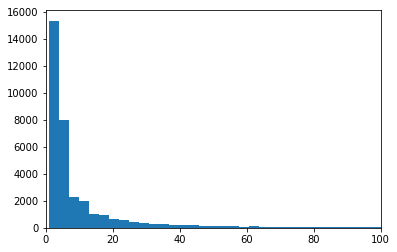

In [39]:
plt.hist(list(clean_dict.values()), bins = 100)
plt.xlim(0, 100)

In [48]:
tokens[0]

'can you please explain what materialism and atheism did to tibet, china or cambodia?'

In [49]:
tokens = nltk.sent_tokenize(raw_text)
lens = [len(s.split(' ')) for s in tokens]

(array([  1.64787000e+05,   3.39600000e+03,   7.00000000e+01,
          1.20000000e+01,   8.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00]),
 array([   1. ,   33.3,   65.6,   97.9,  130.2,  162.5,  194.8,  227.1,
         259.4,  291.7,  324. ]),
 <a list of 10 Patch objects>)

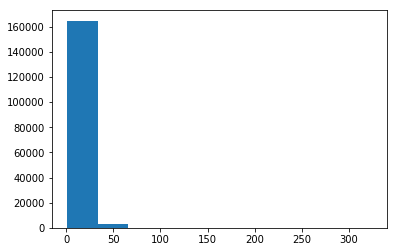

In [51]:
plt.hist(lens)

### Removing Links
1. The format for links is "[link description] (link.link)"

In [ ]:
def contains_link(dictionary):
    """ Determines if the comment contains a link.
    Returns a list of Booleans indicating this.
    """
    return {key: value for key, value in dictionary.items() 
           if fnmatch.fnmatch(value, "*[ * ]*") }

In [ ]:
sample = "This is a test[at](ata)"
import re
import fnmatch

In [ ]:
link_dict = contains_link(values_dict)

In [ ]:
values_dict